In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import ieti_cy, geometry_cy
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
sys.setrecursionlimit(10000)
#import numba as nb    
#from numba import njit

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim = elim
        
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(self.dir_idx[p], return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
            self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        else:
            self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
            self.B = self.space.Constr
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk).tocsr()
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        
        if len(self.dir_idx)>0:
            self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        else:
            self.global_dir_idx = np.array([])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        
        #self.B = self.B @ scipy.sparse.block_diag(self.Basisk)
        
        nnz_per_col = self.B.getnnz(axis=0)
        self.intf_dofs = {}
        for (p1,b1,_),(p2,b2,_),_ in self.space.intfs:
            bdofs2 = assemble.boundary_dofs(kvs[p2],bdspec=[(b2//2,b2%2)],ravel=True)#+self.N_ofs[p2]
            #print(bdofs2)
            constr_idx = (self.Bk[p2][:,bdofs2].getnnz(1)>0)
            bdofs1 = np.where((self.Bk[p1][constr_idx,:]).getnnz(0)>0)[0]
            #print(bdofs1)
            self.intf_dofs[(p1,p2)] = (bdofs1+self.N_ofs[p1], bdofs2+self.N_ofs[p2])
        #self.intf_dofs = {(p1,p2):(assemble.boundary_dofs(kvs[p1],bdspec=[(b1//2,b1%2)],ravel=True)+self.N_ofs[p1],
        #                           assemble.boundary_dofs(kvs[p2],bdspec=[(b2//2,b2%2)],ravel=True)+self.N_ofs[p2]) 
        #                           for (p1,b1,_),(p2,b2,_),_ in self.space.intfs}
        # self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        # self.skeleton = np.union1d(self.intfs, self.global_dir_idx)

        self.Rbb = []
        self.Rii = []
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask = np.zeros(self.N[p], dtype=bool)
            nnz_per_col = self.Bk[p].getnnz(axis=0)
            if p in self.dir_idx:
                intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.dir_idx[p])
            else:
                intfs = np.where(nnz_per_col > 0)[0]
            mask[intfs]=True
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rbb.append(Id[mask].tocsc())
            mask = np.ones(self.N[p], dtype=bool)
            mask[intfs]=False
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rii.append(Id[mask].tocsc())
            
    def assemble(self, problem, f, a):
        self.Ak = [Ba.T @ assemble.assemble(problem, kvs, a=a[self.space.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo)@Ba for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk, self.space.mesh.patches))]
        self.rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.space.mesh.patch_domains[k]]).ravel() for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk,self.space.mesh.patches))]

        self.BCRestr = {p:assemble.RestrictedLinearSystem(self.Ak[p], self.rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk if p not in self.dir_idx else self.BCRestr[p].b for p, rhsk in enumerate(self.rhsk)]
        self.Ak = [Ak if p not in self.dir_idx else self.BCRestr[p].A for p, Ak in enumerate(self.Ak)]
        #self.A = scipy.sparse.block_diag(self.Ak)
        # self.A = BCRestr.A
        # self.rhs = BCRestr.b
        
    def generate_prim(self, elim, fat):
        Nodes = self.space.get_nodes()
        self.Prim = {}
        i=0
        total_dofs=set()
        
        if elim:
            if fat:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                        for dof in dofs:
                            if dof not in total_dofs:
                                total_dofs.add(dof)
                                dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                                self.Prim[i] = (dofs,np.ones(len(dofs)))
                                i+=1
            else:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                        coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                        dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
                        dofs=[]
                        for dof in dofs_coarse:
                            found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            dofs.append(found_dofs)
                        self.Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                        i+=1
        else:
            for key in Nodes:
                if isinstance(key,int32):    #regular corner
                    dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                    self.Prim[i] = (dofs,np.ones(len(dofs)))
                    i+=1
                else:                        #T-junction
                    constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                    coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                    dofs_coarse = Nodes[key][1]
                    dofs=np.concatenate([Nodes[key][0],Nodes[key][1]])
                    coeffs = np.concatenate([np.ones(len(Nodes[key][0])),coeffs])
                    self.Prim[i] = (dofs,coeffs)
                    i+=1
        
    def construct_primal_constraints(self, redundant=False, fat=True):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes(dir_boundary = True)
        
        self.generate_prim(elim=self.elim, fat=fat)

        if self.Prim:
            loc_c_prim = np.concatenate([self.Prim[key][0] for key in self.Prim])
            coeffs = np.concatenate([self.Prim[key][1] for key in self.Prim])
        else:
            loc_c_prim = np.array([])
            coeffs = np.array([])
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
        p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
        self.Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

        self.Rbb_edges = {}
        self.Rbb_edgesP = {}
        for p1,p2 in self.intf_dofs:
            #print(p1,p2)
            arr1, arr2 = self.intf_dofs[(p1,p2)]
            #print(arr1,arr2)
            #self.intf_dofs[(p1,p2)] = (arr1,arr2)
            idx1 = np.zeros(self.Rbb[p1].shape[1])
            idx1[arr1-self.N_ofs[p1]]=1
            idx2 = np.zeros(self.Rbb[p2].shape[1])
            idx2[arr2-self.N_ofs[p2]]=1
            self.Rbb_edgesP[(p1,p2)]=(self.Rbb[p1]@scipy.sparse.diags(idx1),self.Rbb[p2]@scipy.sparse.diags(idx2))
            
            arr1 = np.setdiff1d(self.intf_dofs[(p1,p2)][0],self.Prim_pp[p1][0]).copy() 
            arr2 = np.setdiff1d(self.intf_dofs[(p1,p2)][1], self.Prim_pp[p2][0]).copy()
            #print(arr1, arr2)
            idx1 = np.zeros(self.Rbb[p1].shape[1])
            idx1[arr1-self.N_ofs[p1]]=1
            idx2 = np.zeros(self.Rbb[p2].shape[1])
            idx2[arr2-self.N_ofs[p2]]=1
            self.Rbb_edges[(p1,p2)]=(self.Rbb[p1]@scipy.sparse.diags(idx1),self.Rbb[p2]@scipy.sparse.diags(idx2))

        self.Rbb_prim = {} #{p:self.Rbb[p1]@scipy.sparse.diags(idx1) for p in range(self.space.numpatches)}
        for p in range(self.space.numpatches):
            idx=np.zeros(self.Rbb[p].shape[1])
            idx[self.Prim_pp[p][0]-self.N_ofs[p]]=1
            self.Rbb_prim[p] = self.Rbb[p]@scipy.sparse.diags(idx)
                    
        for p in range(MP.numpatches):
            c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
            data = self.Prim_pp[p][1]
            idx = np.bincount(self.Prim_pp[p][2])
            idx = idx[idx>0]
            rows = np.repeat(np.arange(len(idx)),idx)
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(self.Prim)
            jj = np.unique(self.Prim_pp[p][2])
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
        if not redundant:
            if self.elim:
                if fat:
                    nnz_per_row = self.B[:,np.concatenate([self.Prim_pp[p][0] for p in range(self.space.numpatches)])].getnnz(axis=1)
                    self.eliminate_constraints = np.where(nnz_per_row > 0)[0]
                else:
                    dofs = [Nodes[key][0] for key in Nodes if isinstance(key,int32)]
                    if len(dofs)>0:
                        dofs = np.concatenate([Nodes[key][0] for key in Nodes if isinstance(key,int32)])
                    dofs_new = (self.Basis[dofs,:]==1).indices
                    self.eliminate_constraints = np.where(self.B[:,dofs_new].getnnz(axis=1))
            else:
                self.eliminate_constraints = (MP.Constr.tocsc()[:,np.concatenate([Nodes[key][0] for key in Nodes])]==1).indices
                    
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        self.PsiK=[]
        self.Deltak=[]
        self.loc_solver = []
        self.A_prim = np.zeros(2*(len(self.Prim),))
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            self.loc_solver.append(solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True))
            psi = self.loc_solver[p].dot(RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            self.PsiK.append(psi@self.Rk[p])
            self.Deltak.append(delta)
            self.A_prim -= self.Rk[p].T@delta@self.Rk[p]

        self.Psi=np.vstack(self.PsiK)
        
    def remove_dir_from_system(self):
        self.B = self.B[:,self.free_dofs]
        self.keep = np.where(self.B.getnnz(1)>0)[0]
        self.B=self.B[self.keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        self.Bk = [self.B[:,idx_p[p]] for p in range(self.space.numpatches)]

        for p1,p2 in self.intf_dofs:
            arr1, arr2 = self.intf_dofs[(p1,p2)]
            if p1 in self.dir_idx: arr1 = np.setdiff1d(arr1,self.dir_idx[p1]+self.space.N_ofs[p1])
            if p2 in self.dir_idx: arr2 = np.setdiff1d(arr2, self.dir_idx[p2]+self.space.N_ofs[p2])
            self.intf_dofs[(p1,p2)] = (arr1, arr2)

        self.Rbb = [self.Rbb[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        self.Rii = [self.Rii[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]

        for p1,p2 in self.Rbb_edges:
            rb1, rb2 = self.Rbb_edges[(p1,p2)]
            self.Rbb_edges[(p1,p2)] = (rb1[:,self.free_dofs_pp[p1]],rb2[:,self.free_dofs_pp[p2]]) 
            idx1, idx2 = self.intf_dofs[(p1,p2)]
            self.intf_dofs[(p1,p2)] = (np.where(np.in1d(I.free_dofs,idx1))[0],np.where(np.in1d(I.free_dofs,idx2))[0])

            rb1, rb2 = self.Rbb_edgesP[(p1,p2)]
            self.Rbb_edgesP[(p1,p2)] = (rb1[:,self.free_dofs_pp[p1]],rb2[:,self.free_dofs_pp[p2]]) 
            
        self.Rbb_prim = [self.Rbb_prim[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]

    def compute_F(self):
        #Bk = [b[np.where(b.getnnz(axis=1)>0)[0]] for b in Bk]
        self.Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(self.Bk)] 
        #PTAP = self.A_prim#self.Psi.T@self.A@self.Psi
        #PTBT = self.Psi.T@self.B.T
        BP   = self.B@self.Psi
        
        rhs = np.concatenate(self.rhsk)
        self.rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        
        #self.loc_solver = [solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True) for a,c in zip(self.Ak, self.Ck)]
        self.solver_prim = solvers.make_solver(self.A_prim, spd=True, symmetric=True)
        F1 = aslinearoperator(BP@self.solver_prim.dot(BP.T)) 
        F2 = sum([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(self.Bk_, self.loc_solver)])

        b1 = BP@self.solver_prim.dot(self.Psi.T@rhs)
        b2 = np.sum([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, self.rhsk_)],axis=0)

        #print(self.solver_prim.dot(self.Psi.T@rhs))
        #print([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, rhsk_)])
        
        return F1+F2, b1+b2
    
    def MsD(self, method="diagonal"):
        B = self.B
        Bk = self.Bk
        self.B_gamma = scipy.sparse.hstack([Bk[p]@self.Rbb[p].T for p in range(self.space.numpatches)])

        self.Abb = [aslinearoperator(self.Rbb[p]@self.Ak[p]@self.Rbb[p].T) for p in range(self.space.numpatches)]
        self.Aii = [self.Rii[p]@self.Ak[p]@self.Rii[p].T for p in range(self.space.numpatches)]
        self.Abi = [aslinearoperator(self.Rbb[p]@self.Ak[p]@self.Rii[p].T) for p in range(self.space.numpatches)]
        
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
        # if method=="deluxe":
        #     self.S = [s@np.eye(*s.shape) for s in self.S]
        self.S_ofs = np.cumsum([0]+[s.shape[0] for s in self.S])
        
        if method=="pseudo":   ###TODO: Do not compute matrix exactly but use least squares as an operator
            t=time.time()
            P = np.linalg.pinv(self.B_gamma.toarray())
            P[abs(P)<1e-12]=0
            self.BgD=scipy.sparse.csr_matrix(P).T
            print("Computing pseudoinverse took "+str(time.time()-t)+" seconds.")
        elif method=="diagonal":
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
            self.BgD = self.B_gamma@self.D
        elif method=="selection":
            B = self.B_gamma.tocsc()
            idx = 1*(B.indptr[1:]-B.indptr[:-1]==1) & np.isclose(B.sum(axis=0).A[0],1)
            self.D=scipy.sparse.diags([idx],[0])
            self.BgD = self.B_gamma@self.D
        elif method=="deluxe":
            M_deluxe = []
            for (p1,p2) in self.intf_dofs:
                # idx = self.intf_dofs[(p1,p2)][1]
                # c_idx = self.B[:,idx].tocsc().indices
                # rb1, rb2 = self.Rbb_edges[(p1,p2)]
                # rb1 = rb1[:,rb1.getnnz(0)>0]
                # rb2 = rb2[:,rb2.getnnz(0)>0]
                # s1 = rb1.T@self.S[p1]@rb1
                # s2 = rb2.T@self.S[p2]@rb2
                # P = self.B_gamma[:,self.S_ofs[p1]:self.S_ofs[p1+1]]@rb1
                # P = P[c_idx,:]
                #P2 = self.B_gamma[:,self.S_ofs[p2]:self.S_ofs[p2+1]]@rb2
                #M_deluxe.append(P2@np.linalg.inv(np.linalg.inv(s2) + P@np.linalg.inv(s1)@P.T)@P2.T)
                rb1, rb2 = self.Rbb_edges[(p1,p2)]
                rb1I = scipy.sparse.vstack([self.Rii[p1],rb1[rb1.getnnz(1)>0,:]])
                rb2I = scipy.sparse.vstack([self.Rii[p2],rb2[rb2.getnnz(1)>0,:]])
                A1 = rb1I@self.Ak[p1]@rb1I.T
                A2 = rb2I@self.Ak[p2]@rb2I.T
                B1 = self.Bk[p1]@rb1I.T
                B2 = self.Bk[p2]@rb2I.T

                P2 = self.B_gamma[:,self.S_ofs[p2]:self.S_ofs[p2+1]]@rb2[:,rb2.getnnz(0)>0]
                
                r_idx = B2.getnnz(1)>0
                B1=B1[r_idx ,:]
                B2=B2[r_idx ,:]
                n_c = sum(r_idx)

                Mat = -scipy.sparse.block_array([[A1,None,B1.T],[None,A2,B2.T],[B1,B2,None]])
                n = Mat.shape[0]
                X = aslinearoperator(P2@scipy.sparse.hstack([scipy.sparse.csc_matrix((n_c,n-n_c)),scipy.sparse.identity(n_c, format='csc')]))
                M_deluxe.append(X@solvers.make_solver(Mat)@X.T)
            return np.array(M_deluxe).sum()
            
        print("Convergence condition: "+str(scipy.sparse.linalg.norm(self.B_gamma@self.BgD.T@self.B_gamma-self.B_gamma)))
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        return sum([aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]].T)) for p in range(self.space.numpatches)])

    def construct_solution(self, lam):
        u=np.zeros(self.space.N_ofs[-1])
        u_prim = self.solver_prim.dot(self.Psi.T@(np.concatenate(self.rhsk)-self.B.T@lam))
        for p in range(self.space.numpatches):
            sol = self.loc_solver[p].dot(np.r_[self.rhsk[p]-self.Bk[p].T@lam,np.zeros(self.Ck[p].shape[0])])[:self.Ck[p].shape[1]] + self.PsiK[p]@u_prim
            if p in self.BCRestr:
                sol = self.BCRestr[p].complete(sol)
            u[self.space.N_ofs[p]:self.space.N_ofs[p+1]]=self.Basisk[p]@sol
        return u
        

In [3]:
def checkerboard(deg,N,k=0):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    ]

    kvs=4*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(4) if i%2==1})
    return M

In [4]:
def checkerboard1(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [5]:
def checkerboard2(deg,N,k):
    geos = [
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/3),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==0})
    return M

In [6]:
def Lshape(deg, N, depth=0):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.annulus(r1=1.5,phi=np.pi/4),
        geometry.annulus(r1=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
        geometry.annulus(r1=1,r2=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    for i in range(depth):
        refine = np.where([np.any([np.allclose(row,1.5*np.array([np.cos(np.pi/4),np.sin(np.pi/4)])) for row in topology.corners(geo,ravel=1)]) for geo in M.geos])[0]
        M.h_refine({patch:None for patch in refine})
    
    return M

In [7]:
def Central(deg, N, depth=0):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.annulus()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine({0:1})
    M.h_refine({1:0})
    M.set_domain_id({1:{0}})

    for i in range(depth):
        refine = np.where([np.any([np.allclose(row,1.5*np.array([np.cos(np.pi/4),np.sin(np.pi/4)])) for row in topology.corners(geo,ravel=1)]) for geo in M.geos])[0]
        M.h_refine({patch:None for patch in refine})
    return M

In [8]:
def Tshapes(deg,N,depth=0):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine({0:1})
    for i in range(depth):
        M.h_refine({j:0 for j in range(1,len(M.geos))})
    return M

In [9]:
def example_geo(deg, N):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.quarter_annulus())]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0});
    M.h_refine({1:1});
    M.h_refine({1:0});
    M.h_refine({1:1});
    M.h_refine({4:0});
    #M.h_refine({1:1});
    return M

In [10]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [11]:
def parametersort(MP,a):
    B = scipy.sparse.csr_matrix(MP.Constr)
    idx = np.where(B.getnnz(1)==2)[0]
    D = np.array(list(MP.mesh.patch_domains.values()), dtype=int)
    I = B[idx].indices.reshape(len(idx),2)
    P = np.array([p*((MP.N_ofs[p]<= I) & (I < MP.N_ofs[p+1])) for p in range(MP.numpatches)]).sum(axis=0)
    A = np.array(list(a.values()))
    R = A[D[P]]*B[idx].data.reshape(len(idx),2)[:,1][:,newaxis]
    B[idx[R[:,0]<R[:,1]]]*=-1
    return B

In [79]:
deg = 1
N = 10
M = Central(deg,N,0)
MP = assemble.Multipatch(M, automatch=True)
dir_data = {0: lambda x,y: 0.}
MP.set_dirichlet_boundary(dir_data)
a = {0:1e6, 1:1.}
f={0:lambda x,y: 1.,1:lambda x,y: 1.}

#MP.h_refine({1:0})
#MP.h_refine({3:None, 6:None, 8:None, 10:None})
#MP.h_refine({26:None})
MP.set_dirichlet_boundary(dir_data)

#MP.Constr = parametersort(MP,a)

I = IetiDP(MP, dir_data = dir_data, elim=0)
I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=f, a=a)
I.construct_primal_constraints(redundant=False, fat = False)
I.construct_primal_basis()
I.remove_dir_from_system()

F,b = I.compute_F()
F_mat = F@np.eye(F.shape[0])
MsD = I.MsD(method = "selection")  #just to initialise I.S_ofs[]

MsD = np.zeros(F.shape)
for (p1,p2) in I.intf_dofs:
    rb1, rb2 = I.Rbb_edges[(p1,p2)]
    rb1P, rb2P = I.Rbb_edgesP[(p1,p2)]
    
    rb1I = scipy.sparse.vstack([I.Rii[p1],rb1[rb1.getnnz(1)>0,:]])
    rb2I = scipy.sparse.vstack([I.Rii[p2],rb2[rb2.getnnz(1)>0,:]])
    rb1IP = scipy.sparse.vstack([I.Rii[p1],rb1P[rb1P.getnnz(1)>0,:]])
    rb2IP = scipy.sparse.vstack([I.Rii[p2],rb2P[rb2P.getnnz(1)>0,:]])

    if p1==1 and p2==2:
        A1 = rb1I@I.Ak[p1]@rb1I.T
        B1 = I.Bk[p1]@rb1I.T
    else:
        A1 = rb1I@I.Ak[p1]@rb1I.T
        B1 = I.Bk[p1]@rb1I.T

    A2 = rb2I@I.Ak[p2]@rb2I.T
    B2 = I.Bk[p2]@rb2I.T

    #P1 = I.B_gamma[:,I.S_ofs[p1]:I.S_ofs[p1+1]]@rb1[:,rb1.getnnz(0)>0]
    P2 = I.B_gamma[:,I.S_ofs[p2]:I.S_ofs[p2+1]]@rb2[:,rb2.getnnz(0)>0]
                
    r_idx = B2.getnnz(1)>0
    B1=B1[r_idx ,:]
    B2=B2[r_idx ,:]
    n_c = sum(r_idx)

    Mat = scipy.sparse.block_array([[A1,None,B1.T],[None,A2,B2.T],[B1,B2,None]])
    n = Mat.shape[0]
    X = aslinearoperator(P2@scipy.sparse.hstack([scipy.sparse.csc_matrix((n_c,n-n_c)),scipy.sparse.identity(n_c, format='csc')]))
    MsD -= X@np.linalg.inv(Mat.toarray())@X.T
    #print(X@np.linalg.inv(Mat.toarray())@X.T)
    #M_deluxe.append(X@solvers.make_solver(Mat)@X.T)
#M_deluxe = sum(M_deluxe)
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)

# print(MsD@F_mat)
# print(np.linalg.cond(MsD@F_mat))

setting up constraints took 0.008687973022460938 seconds.
Basis setup took 0.003956794738769531 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 1.3670531603236002 stopped after 4 iterations with relres 3.431587897866696e-10


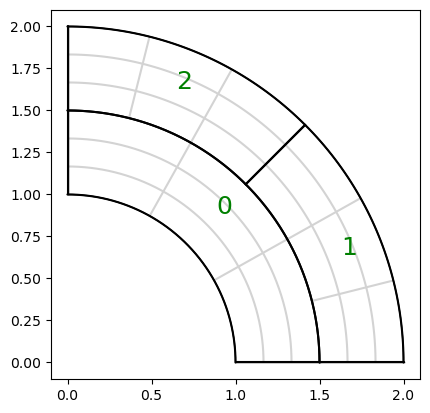

In [61]:
M.draw(knots=1,patch_idx=1)

In [62]:
I.intf_dofs

{(0, 1): (array([2, 5]), array([ 6,  9, 12])),
 (1, 2): (array([12, 13, 14]), array([15, 16, 17])),
 (0, 2): (array([2, 5]), array([15, 18, 21]))}

In [47]:
I.Prim_pp

{0: (array([ 7, 11]), array([0.5, 0.5]), array([0, 0])),
 1: (array([28]), array([1.]), array([0])),
 2: (array([32]), array([1.]), array([0]))}

In [48]:
I.Rbb_edgesP[(0,1)][0].toarray()

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [49]:
I.Rbb_edges[(0,1)][0].toarray()

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [63]:
bdofs2 = np.array([0,1,2,3,4])

In [588]:
constr_idx=(I.Bk[2][:,bdofs2].getnnz(1)>0)

In [591]:
np.where((I.Bk[1][constr_idx,:]).tocsc().getnnz(0)>0)[0]+25

array([45, 46, 47, 48, 49])

setting up constraints took 0.011276006698608398 seconds.
Basis setup took 0.006053924560546875 seconds


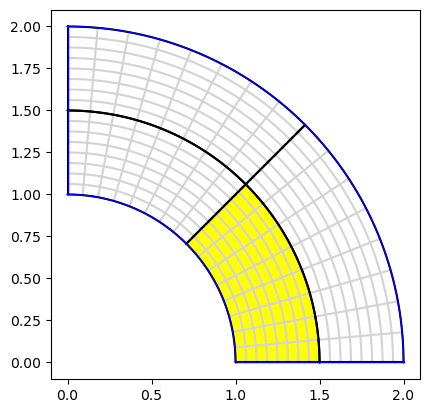

Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 5.358987053589422 stopped after 7 iterations with relres 4.33018882422821e-07
Residual contributions took 0.03898763656616211 seconds.
Jump contributions took 0.03082728385925293 seconds.
Refinement took 0.016651153564453125 seconds for 4 patches.
setting up constraints took 0.05524134635925293 seconds.
Basis setup took 0.008200883865356445 seconds


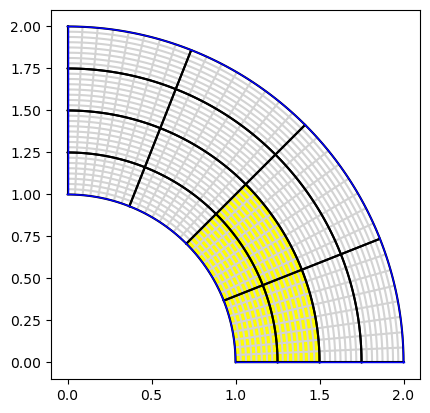

Convergence condition: 1.6011864169946884e-15
pcg with preconditioned condition number κ ~ 14.833379922519352 stopped after 19 iterations with relres 8.448471225066901e-07
Residual contributions took 0.15200209617614746 seconds.
Jump contributions took 0.17528772354125977 seconds.
Refinement took 0.013027429580688477 seconds for 4 patches.
setting up constraints took 0.08823323249816895 seconds.
Basis setup took 0.01707744598388672 seconds


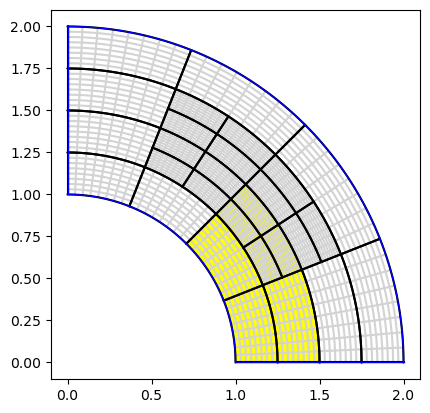

Convergence condition: 2.3498992183808826e-15
pcg with preconditioned condition number κ ~ 15.72440666345194 stopped after 24 iterations with relres 7.2533859284789e-07
Residual contributions took 0.23334360122680664 seconds.
Jump contributions took 0.3753833770751953 seconds.
Refinement took 0.015390157699584961 seconds for 4 patches.
setting up constraints took 0.13606023788452148 seconds.
Basis setup took 0.023336410522460938 seconds


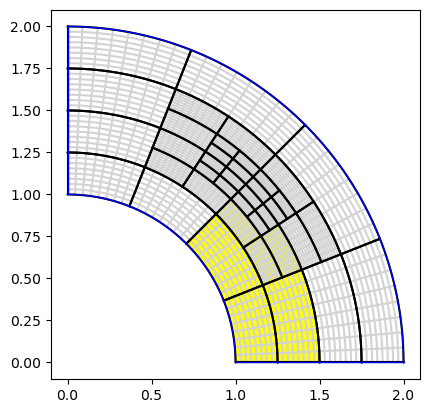

Convergence condition: 2.6645352591003757e-15
pcg with preconditioned condition number κ ~ 16.1355781624915 stopped after 25 iterations with relres 8.598232703240204e-07
Residual contributions took 0.35608863830566406 seconds.
Jump contributions took 0.5800132751464844 seconds.
Refinement took 0.017069578170776367 seconds for 4 patches.
setting up constraints took 0.18324542045593262 seconds.
Basis setup took 0.0287020206451416 seconds


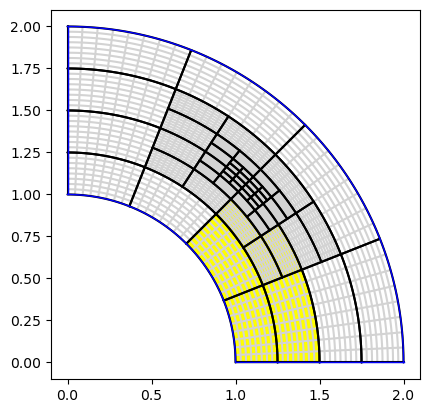

Convergence condition: 3.607797795906347e-15
pcg with preconditioned condition number κ ~ 16.25415357630567 stopped after 26 iterations with relres 6.628224652880657e-07
Residual contributions took 0.45270347595214844 seconds.
Jump contributions took 0.7662129402160645 seconds.
Refinement took 0.018680095672607422 seconds for 4 patches.
setting up constraints took 0.2307298183441162 seconds.
Basis setup took 0.033536672592163086 seconds


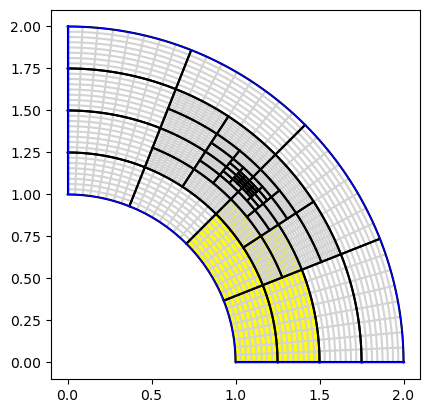

Convergence condition: 3.9471512357794175e-15
pcg with preconditioned condition number κ ~ 16.275474321918427 stopped after 26 iterations with relres 8.183523758063225e-07
Residual contributions took 0.5453164577484131 seconds.
Jump contributions took 0.9782180786132812 seconds.
Refinement took 0.021194934844970703 seconds for 4 patches.
setting up constraints took 0.2835962772369385 seconds.
Basis setup took 0.04138612747192383 seconds


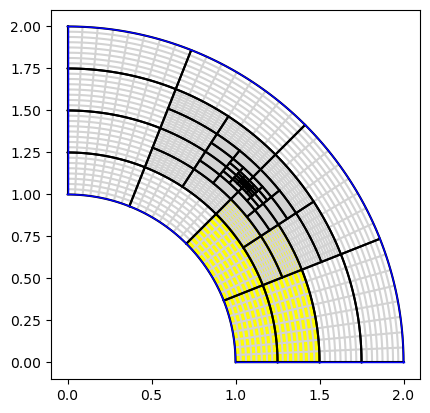

Convergence condition: 4.328446199157271e-15
pcg with preconditioned condition number κ ~ 16.282936732621465 stopped after 26 iterations with relres 8.496188370017173e-07
Residual contributions took 0.6577513217926025 seconds.
Jump contributions took 1.162194013595581 seconds.
Refinement took 0.02552056312561035 seconds for 4 patches.
setting up constraints took 0.3256266117095947 seconds.
Basis setup took 0.04545927047729492 seconds


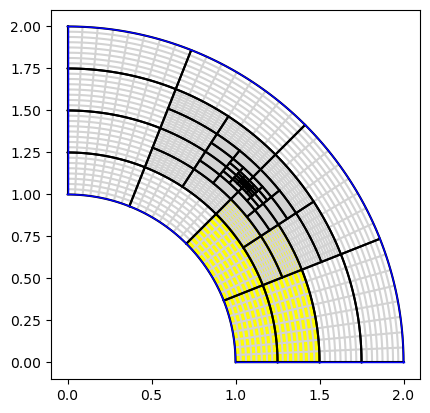

Convergence condition: 4.7207330545682824e-15
pcg with preconditioned condition number κ ~ 16.28698300988419 stopped after 26 iterations with relres 8.463466644721843e-07
Residual contributions took 0.7569561004638672 seconds.
Jump contributions took 1.3625304698944092 seconds.
Refinement took 0.024790525436401367 seconds for 4 patches.
setting up constraints took 0.37459588050842285 seconds.
Basis setup took 0.05223965644836426 seconds


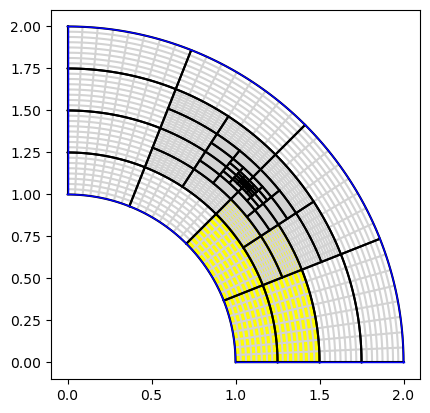

Convergence condition: 4.884981308350689e-15
pcg with preconditioned condition number κ ~ 16.287147516721884 stopped after 26 iterations with relres 9.544342766352929e-07
Residual contributions took 0.8554587364196777 seconds.
Jump contributions took 1.5615825653076172 seconds.
Refinement took 0.02544260025024414 seconds for 4 patches.
setting up constraints took 0.41647863388061523 seconds.
Basis setup took 0.05226945877075195 seconds


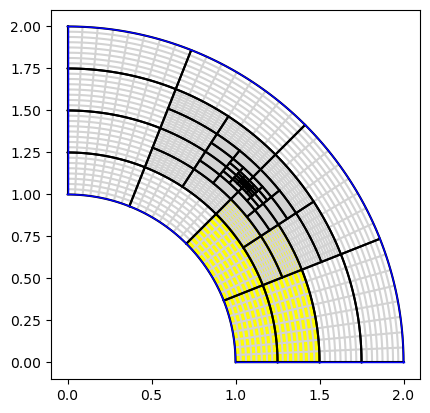

Convergence condition: 4.884981308350689e-15
pcg with preconditioned condition number κ ~ 16.302765321051933 stopped after 27 iterations with relres 5.933022415120111e-07


In [208]:
deg = 5
N = 8
M = Heat_annulus(deg,N)
MP = assemble.Multipatch(M, automatch=True)

dir_data = {0: lambda x,y: 0.}
MP.set_dirichlet_boundary(dir_data)
uh=[]
P=[]
err_ind=[]

maxiter=10
numdofs =np.zeros(maxiter)
err_est=np.zeros(maxiter)
a = {0:1., 1:1e4}
f={0:lambda x,y: 1.,1:lambda x,y: 1.}

MP.Constr = parametersort(MP,a)

for k in range(maxiter):
    n_p = MP.numpatches
    MP.mesh.draw(knots=1,patch_idx=0,color={0:'white',1:'yellow'},bcolor={0:'blue'})
    plt.show()

    ###Direct solver
    # bcs = MP.compute_dirichlet_bcs({0:0.})
    # Ah = MP.assemble_volume(vform.stiffness_vf(2,a=a[0]),domain_id=0) + MP.assemble_volume(vform.stiffness_vf(2,a=a[1]),domain_id=1)
    # Kh = MP.assemble_volume(vform.stiffness_vf(2))
    # Mh = MP.assemble_volume(vform.mass_vf(2))
    # F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
    # LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    # uh_k = solvers.make_solver(LS.A)@LS.b
    # uh_k = LS.complete(uh_k)

    ###IETI Solver
    I = IetiDP(MP, dir_data = dir_data, elim=0)
    I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=f, a=a)
    I.construct_primal_constraints(redundant=False, fat = 0)
    I.construct_primal_basis()
    I.remove_dir_from_system()

    F,b = I.compute_F()
    MsD = I.MsD(method = "selection")

    lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
    uh_k = I.construct_solution(lam)
    
    uh.append(uh_k)
    numdofs[k] = MP.numdofs
    #print(MP_a.numdofs)
    
    if k < maxiter-1 :
        err_ind.append(adap.mp_resPois(MP,uh[k],a=a, f=f))
        err_est[k] = norm(err_ind[-1])
        marked_patches = adap.doerfler_mark(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        #print(marked_patches)
        MP.h_refine(h_ref=marked_patches,ref="rs")
        MP.set_dirichlet_boundary(dir_data)
        MP.Constr = parametersort(MP,a)
        #P.append(MP.h_refine(h_ref=marked_patches, return_P=True))
        #MP_a.mesh.draw(plt.figure())
    # elif i == maxiter-2:
    #     P.append(MP_a.p_refine(p_inc=1, return_P=True))
    # else:
    #     pass
    
# for k in reversed(range(1,len(P_a))):
#     P_a[k-1]=P_a[k]@P_a[k-1]
    
# L2err_a = np.zeros(maxiter)
# H1err_a = np.zeros(maxiter)
# Aherr_a = np.zeros(maxiter)
# for i in range(len(uh_a)-1):
#     eh = P_a[i]@uh_a[i]-uh_a[-1]
#     L2err_a[i] = eh @ Mh_a @ eh
#     H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
#     Aherr_a[i] = eh @ Ah_a @ eh

# L2err_a = sqrt(L2err_a)
# H1err_a = sqrt(H1err_a)
# Aherr_a = sqrt(Aherr_a)

In [209]:
I.A_prim.shape

(137, 137)

In [144]:
bspline.prolongation(bspline.make_knots(1,0,1,5),bspline.make_knots(1,0,1,10)).toarray()

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 1. ]])

setting up constraints took 0.007612943649291992 seconds.
Basis setup took 0.0040585994720458984 seconds


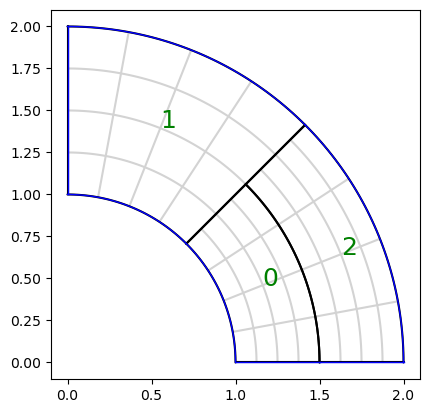

In [27]:
f = lambda x, y: x+y
g = lambda x, y: 0.

params = {'f' : f, 'g' : g}
deg = 1
N = 4
elim=0
fat=0

#M = Heat_annulus(deg,N)
M = topology.PatchMesh(patches=[(2*[bspline.make_knots(deg,0,1,N)],geometry.quarter_annulus())])
M.h_refine({0:0})
M.h_refine({0:1})
# M.h_refine({0:0})
# M.h_refine({1:1})
# M.h_refine({0:1})

#M.h_refine({3:None})
#M.split_patch(0)
#M = Lshape(deg,N,0
#M = topology.PatchMesh(list(zip(5*(2*(bspline.make_knots(deg,0,1,N),),),geometry.mp_disk())))
MP = assemble.Multipatch(M, automatch=True)
dir_data = {0:g}
MP.set_dirichlet_boundary(dir_data)
N = MP.numpatches
MP.mesh.draw(patch_idx=1,nodes=0,knots=1,bcolor={0:'blue'},color={0:'white',1:'yellow'})
I = IetiDP(MP, dir_data = {0:g}, elim=elim)
I.assemble(problem='a*inner(grad(u),grad(v))* dx',f={0:lambda x,y: x+y}, a={0:1.})
I.construct_primal_constraints(redundant=False, fat = fat)
I.construct_primal_basis()
I.remove_dir_from_system()
F,b = I.compute_F()
# F_mat = F@np.eye(*F.shape)
#I.compute_Schur(asmatrix = True)
#print(np.max(I.Psi))
#print(norm(b))
#I.compute_Schur(asmatrix=1)
#MsD = I.MsD(method = "diagonal")
x0 = None
#x0 = np.random.rand(len(b))
#lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
#lam, info = scipy.sparse.linalg.cg(F, b, x0=x0, maxiter=2000, M = MsD, rtol=1e-5, atol=1e-12)
#print(info)
#print(min_eig, max_eig)
#u_loc0 = I.construct_solution(lam0)
#u_loc = I.construct_solution(lam)
#MP.plot(np.concatenate(u_loc))

In [35]:
MsD= I.MsD(method = "selection")
S = [s@np.eye(*s.shape) for s in I.S]
M_deluxe = np.zeros(F.shape)
for (p1,p2) in I.intf_dofs:
    print(p1,p2)
    rb1, rb2 = I.Rbb_edges[(p1,p2)]
    rb1I = scipy.sparse.vstack([I.Rii[p1],rb1[rb1.getnnz(1)>0,:]])
    rb2I = scipy.sparse.vstack([I.Rii[p2],rb2[rb2.getnnz(1)>0,:]])
    A1 = rb1I@I.Ak[p1]@rb1I.T
    A2 = rb2I@I.Ak[p2]@rb2I.T
    B1 = I.Bk[p1]@rb1I.T
    B2 = I.Bk[p2]@rb2I.T

    idx = I.intf_dofs[(p1,p2)][1]
    c_idx = I.B[:,idx].tocsc().indices
    rb1, rb2 = I.Rbb_edges[(p1,p2)]
    rb1 = rb1[:,rb1.getnnz(0)>0]
    rb2 = rb2[:,rb2.getnnz(0)>0]

    s1 = rb1.T@S[p1]@rb1
    s2 = rb2.T@S[p2]@rb2
    P = I.B_gamma[:,I.S_ofs[p1]:I.S_ofs[p1+1]]@rb1
    P = P[c_idx,:]

    P2 = I.B_gamma[:,I.S_ofs[p2]:I.S_ofs[p2+1]]@rb2[:,rb2.getnnz(0)>0]
                
    #Z = scipy.sparse.hstack([B1,B2])
    r_idx = B2.getnnz(1)>0
    B1=B1[r_idx ,:]
    B2=B2[r_idx ,:]
    #print(B1.toarray(),B2.toarray())
    n_c = sum(r_idx)

    Mat = -scipy.sparse.block_array([[A1,None,B1.T],[None,A2,B2.T],[B1,B2,None]])
    #print(Mat.toarray())
    # spy(Mat,markersize=1)
    # plt.show()
    n = Mat.shape[0]
    X = aslinearoperator(P2@scipy.sparse.hstack([scipy.sparse.csc_matrix((n_c,n-n_c)),scipy.sparse.identity(n_c, format='csc')]))
    #print(n_c,X@np.eye(X.shape[1]))
    Mat_inv = solvers.make_solver(Mat, spd=False, symmetric=True)
    #print(Mat_inv.toarray())
    print((X@Mat_inv@X.T)@np.eye(X.shape[0]))
    print(P2@np.linalg.inv(np.linalg.inv(s2) + P@np.linalg.inv(s1)@P.T)@P2.T)
    print("===========================================================================================================================================================")

Convergence condition: 0.0
1 0
[[ 1.51761 -0.61938 -0.0595   0.       0.       0.       0.       0.       0.     ]
 [-0.61938  1.16221 -0.68892  0.       0.       0.       0.       0.       0.     ]
 [-0.0595  -0.68892  1.69235  0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
[[ 1.51761 -0.61938 -0.0595   0.       0.       0.       0.       0.       0.     ]
 [-0.61938  1.16221 -0.68892  0.       0.       0.       0.       0.       0.     ]
 [-0.0595  -0.68892  1.69235  0.       0.   

In [ ]:
np.hstack([np.zeros(shape=(len(c_idx),rb1.shape[0]+rb2.shape[0])),np.eye(len(c_idx))])

In [ ]:
rb2

In [44]:
rb2_tilde.toarray()

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
MsD= I.MsD(method = "deluxe")

In [38]:
algebra.condest(F_mat)

145.87277360530817

In [39]:
MsD = MsD@np.eye(*F.shape)

In [40]:
algebra.condest(MsD@F_mat)

20.168438075051302

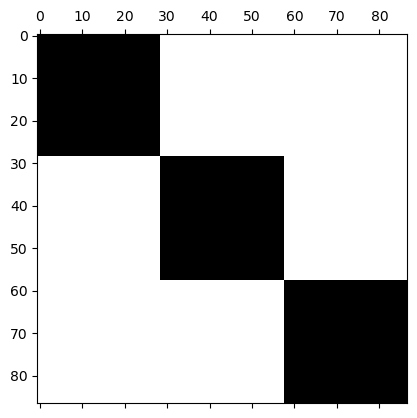

In [156]:
spy(MsD)

deg = 2
setting up constraints took 0.020328521728515625 seconds.
Basis setup took 0.008057832717895508 seconds
pcg with preconditioned condition number κ ~ 4.866912722164114 stopped after 12 iterations with relres 4.0196249089061476e-07
#####################################################
setting up constraints took 0.021007776260375977 seconds.
Basis setup took 0.008074045181274414 seconds
pcg with preconditioned condition number κ ~ 6.844477130703723 stopped after 15 iterations with relres 1.2527597848017955e-07
#####################################################
setting up constraints took 0.02991962432861328 seconds.
Basis setup took 0.016133785247802734 seconds
pcg with preconditioned condition number κ ~ 9.146446269810777 stopped after 16 iterations with relres 8.252901247665778e-07
#####################################################
deg = 3
setting up constraints took 0.021846532821655273 seconds.
Basis setup took 0.007699489593505859 seconds
pcg with preconditioned condit

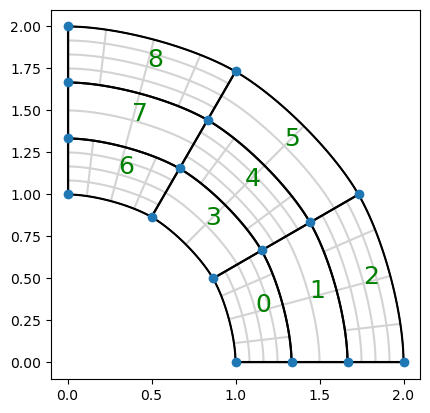

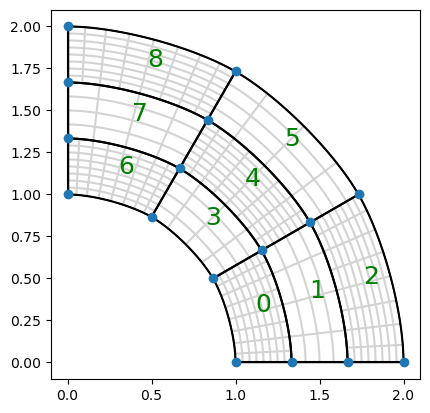

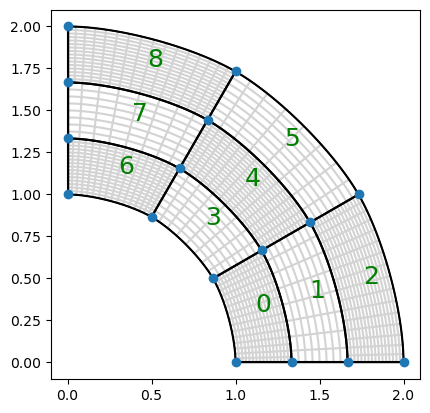

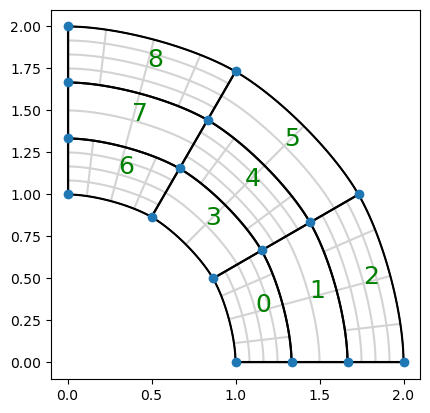

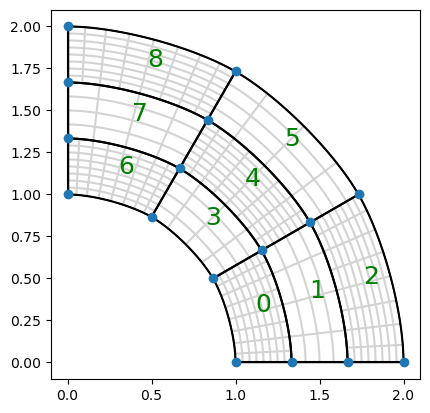

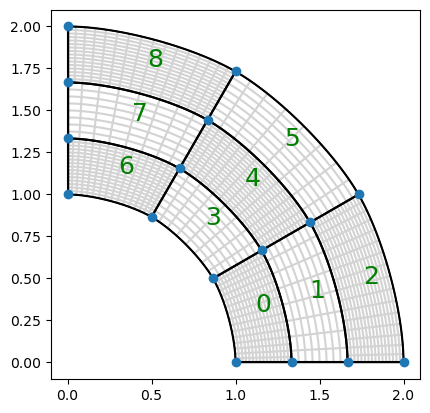

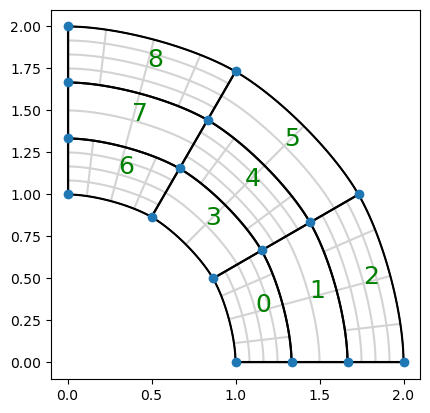

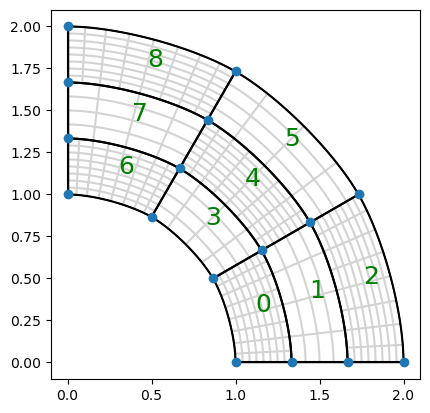

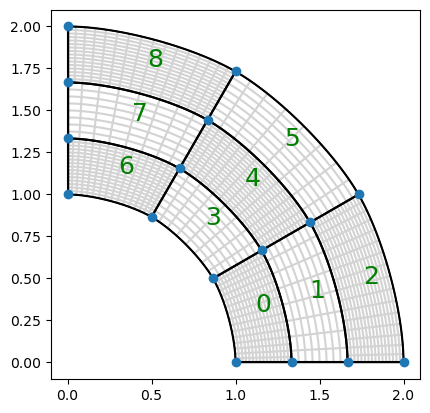

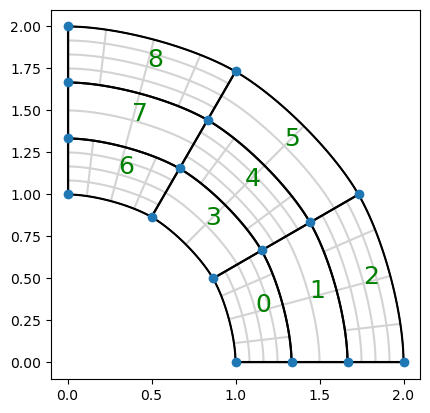

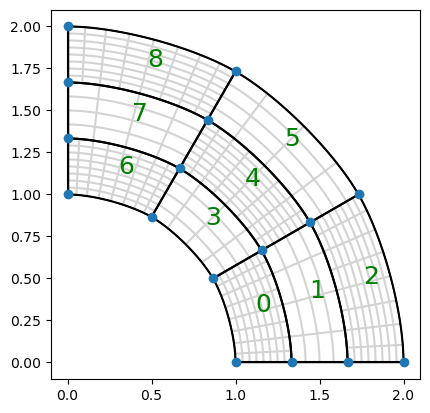

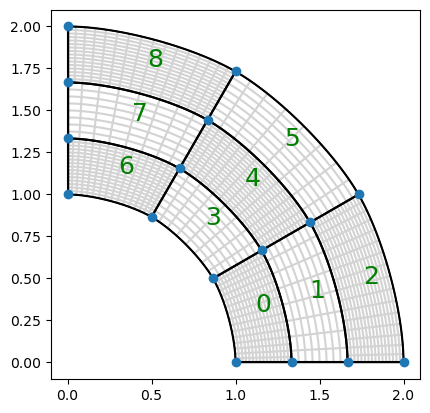

In [119]:
# f = lambda x, y: 1.
g = lambda x, y: 0. 

#params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(3,)
elim=0
fat=0
export=1
a={0:1e6,1:1.}

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = checkerboard2(deg,2**(i+1),1)
        M.set_domain_id({1:{1,3,5,7}})
        MP = assemble.Multipatch(M, automatch=True)
        N = MP.numpatches
        MP.set_dirichlet_boundary({0:g})
        MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='a * inner( grad(u) , grad(v) )* dx', f={0:lambda x,y: 1.,1:lambda x,y: 1.}, a=a)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_system()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        #I.compute_Schur()
        MsD = I.MsD(method="deluxe")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=2000, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[i, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [ ]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,4,5,6,7,8)
maxiter=len(degs)*(6,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for d in range(maxiter[j]):
        M = checkerboard1(deg,2,d+1)
        MP = assemble.Multipatch(M, automatch=True)
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f={ k:lambda x,y: 1. for k in range(N)}, a={ k:lambda x,y: 1. for k in range(N)})
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="choice")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[d,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=100, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[d, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [165]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(4,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = Lshape(deg,2**(i+1),5)
        MP = assemble.Multipatch(M, automatch=True)
        N = MP.numpatches
        #res[i,k*j] = MP.N_ofs[-1]
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f={ k:lambda x,y: 1. for k in range(N)}, a={ k:lambda x,y: 1. for k in range(N)})
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        print(I.Psi.shape[1])
        I.remove_dir_from_system()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="deluxe")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        #x0=np.random.rand(len(b))
        x0=None
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        #print(min_eig, max_eig)
        res[i,k*j+1]=abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        if fat:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim_fat.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   
        else:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ") 
    else:
        np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   

deg = 2
setting up constraints took 0.13743233680725098 seconds.
Basis setup took 0.0164334774017334 seconds
49
pcg with preconditioned condition number κ ~ 5.672835943596938 stopped after 16 iterations with relres 4.6732528639194114e-07
#####################################################
setting up constraints took 0.142197847366333 seconds.
Basis setup took 0.016907453536987305 seconds
49
pcg with preconditioned condition number κ ~ 8.81675154323183 stopped after 18 iterations with relres 5.947188239080794e-07
#####################################################
setting up constraints took 0.15126681327819824 seconds.
Basis setup took 0.019551753997802734 seconds
49
pcg with preconditioned condition number κ ~ 13.437801942087457 stopped after 21 iterations with relres 5.856498528403269e-07
#####################################################
setting up constraints took 0.1742088794708252 seconds.
Basis setup took 0.02640557289123535 seconds
49
pcg with preconditioned condition nu

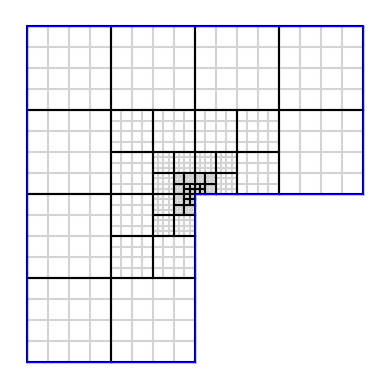

In [27]:
M = Lshape(1,4,5)
M.draw(bcolor={0:'blue'}, nodes=0, knots=1)
axis('off');

In [8]:
I.Ck

[<1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x49 sparse matrix of type '<class 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compr

In [9]:
I.Prim

{0: (array([ 48, 189, 202, 245], dtype=int32), array([1., 1., 1., 1.])),
 1: (array([ 97, 336, 349, 392], dtype=int32), array([1., 1., 1., 1.])),
 2: (array([140, 342, 398, 490], dtype=int32), array([1., 1., 1., 1.])),
 3: (array([146, 483, 496, 539], dtype=int32), array([1., 1., 1., 1.])),
 4: (array([ 55, 244, 287, 294], dtype=int32), array([1., 1., 1., 1.]))}

In [10]:
MP.get_nodes()

{48: [array([ 48, 189, 202, 245], dtype=int32)],
 96: [array([ 97, 336, 349, 392], dtype=int32)],
 138: [array([140, 342, 398, 490], dtype=int32)],
 144: [array([146, 483, 496, 539], dtype=int32)],
 252: [array([ 55, 244, 287, 294], dtype=int32)]}

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

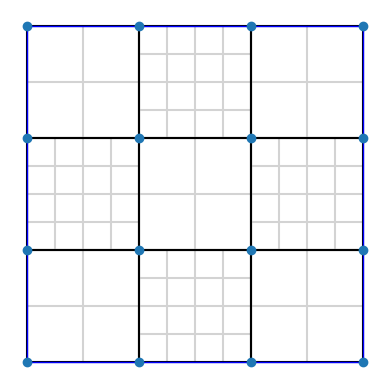

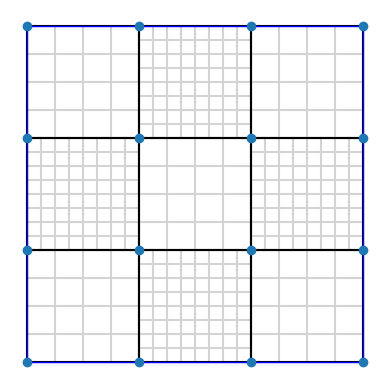

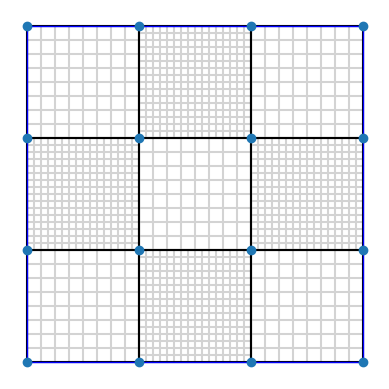

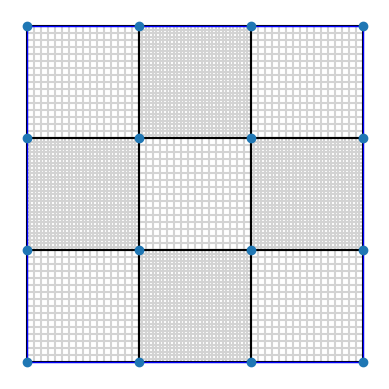

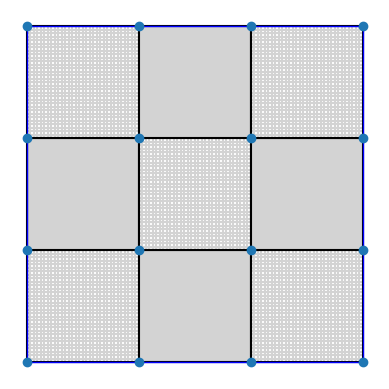

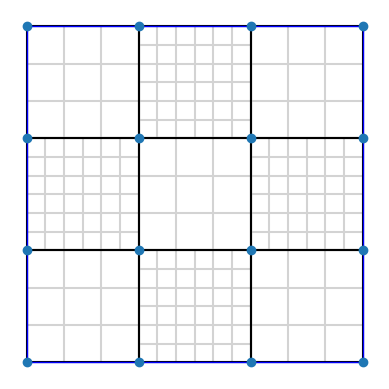

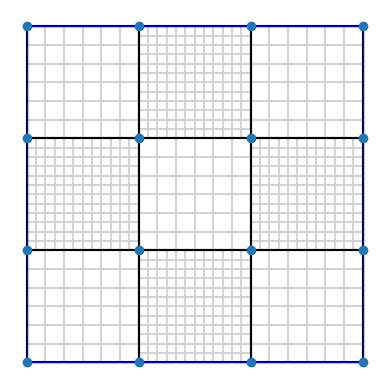

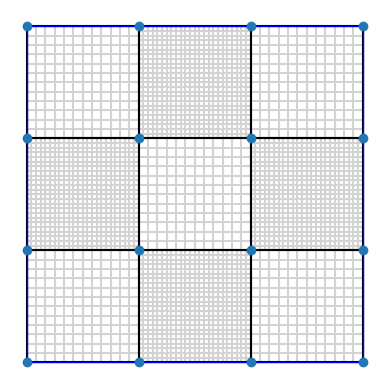

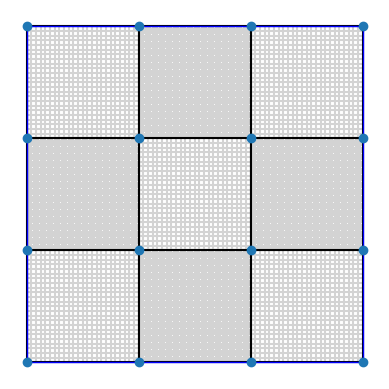

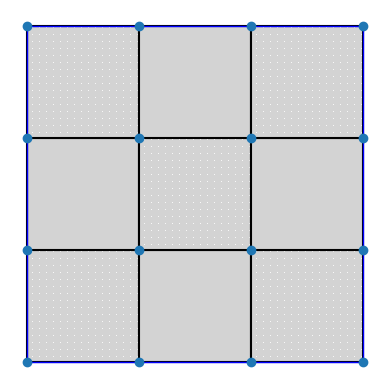

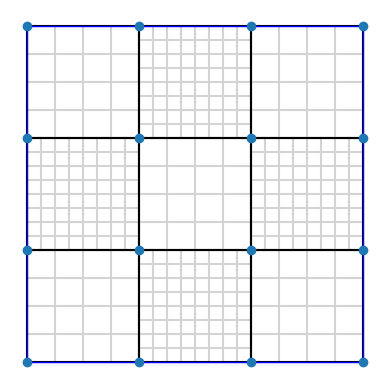

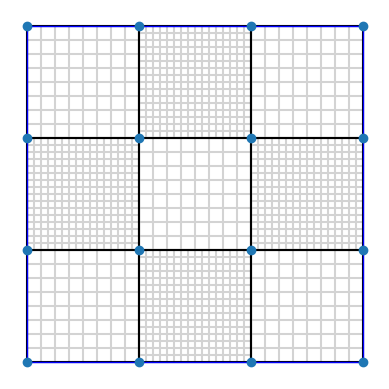

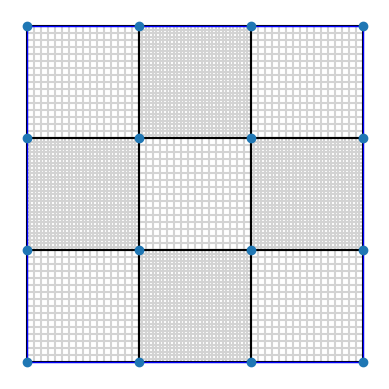

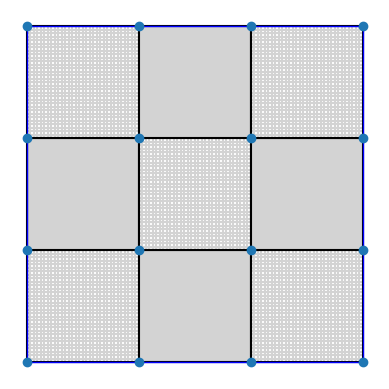

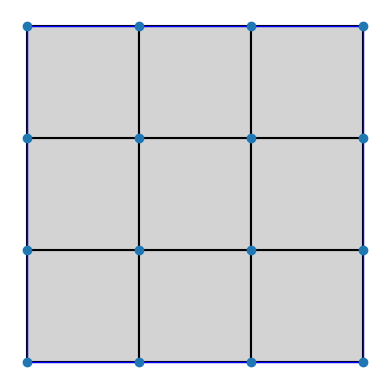

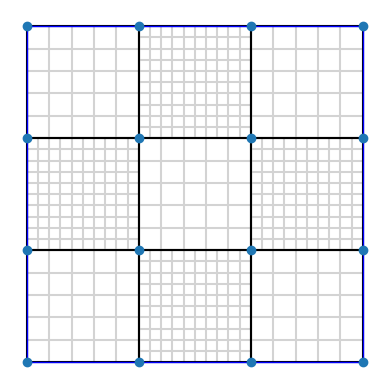

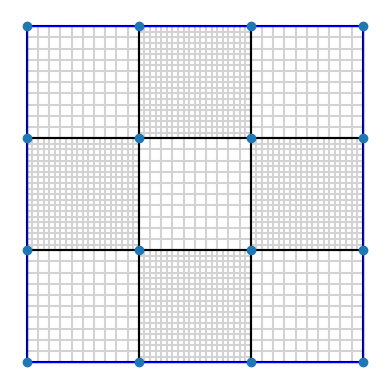

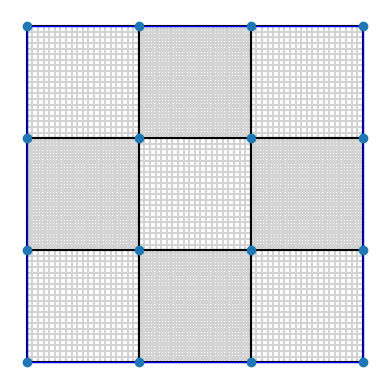

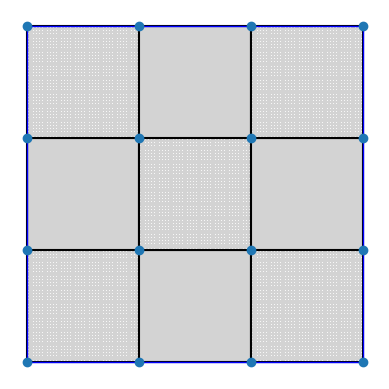

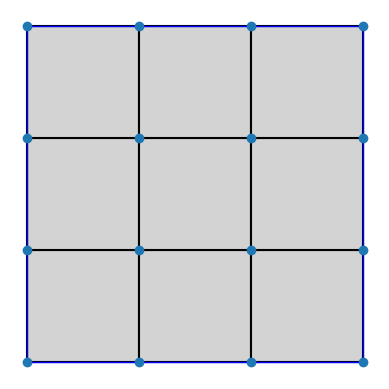

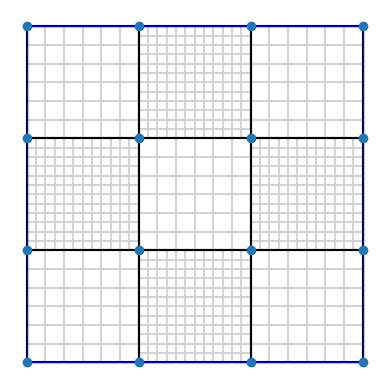

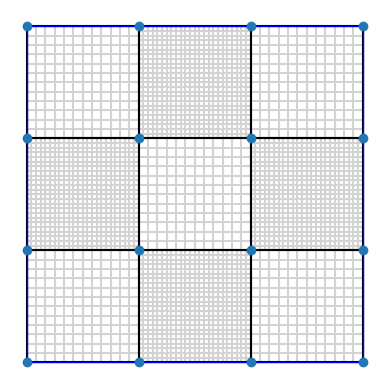

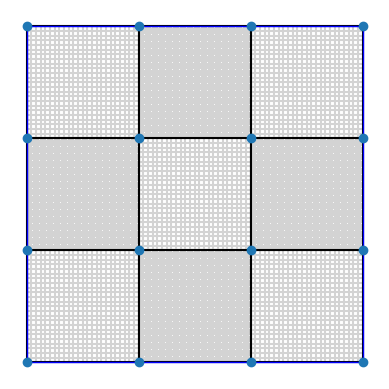

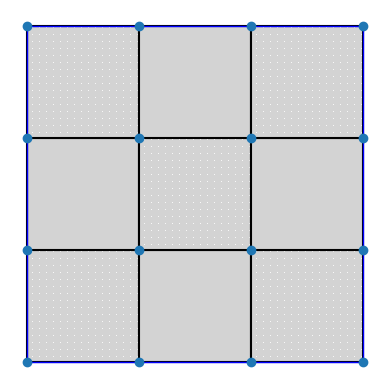

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

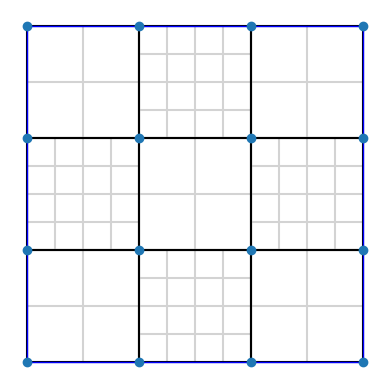

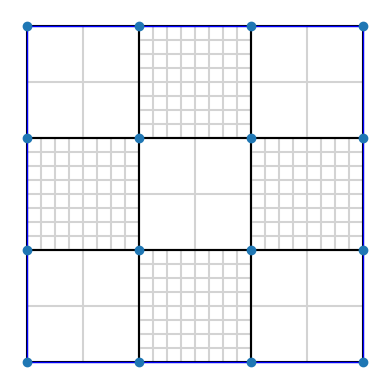

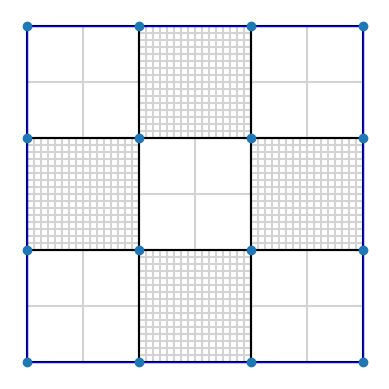

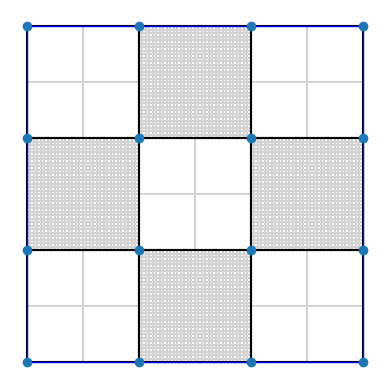

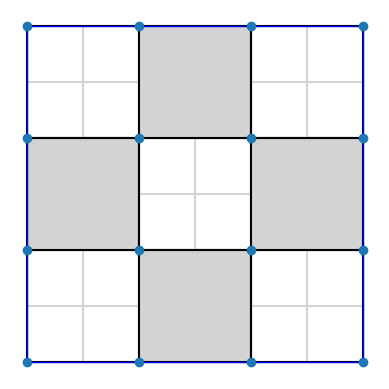

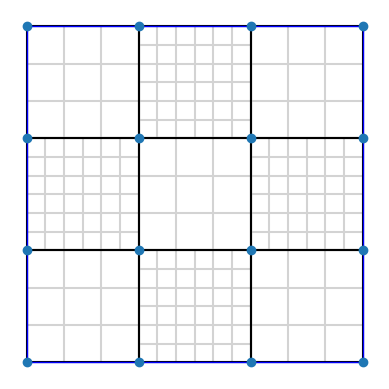

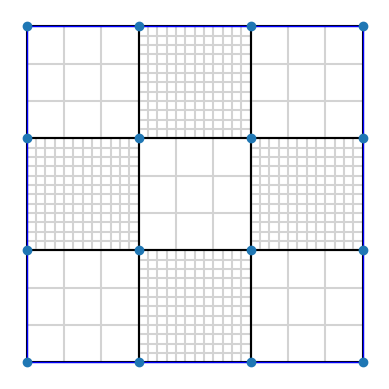

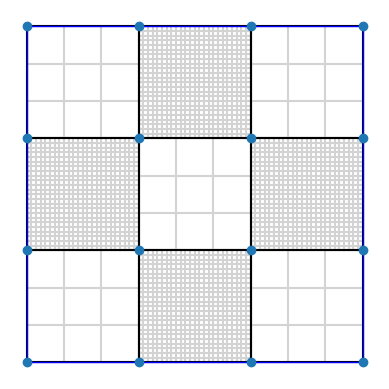

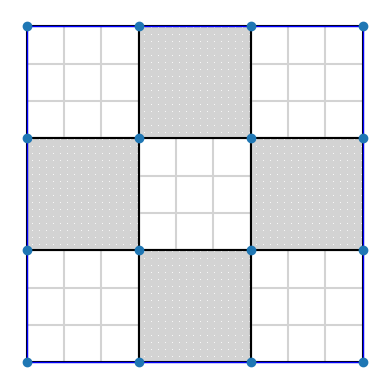

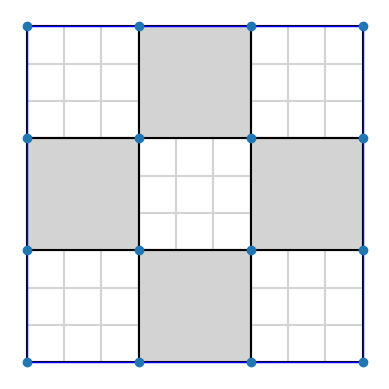

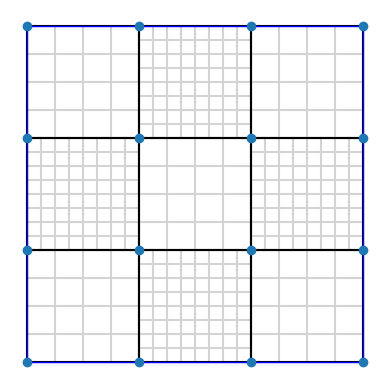

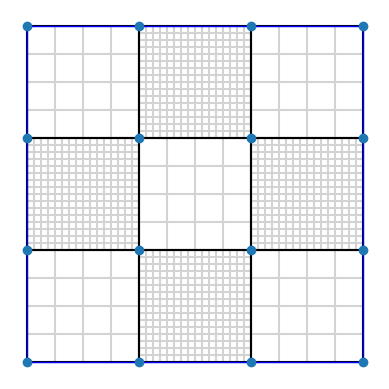

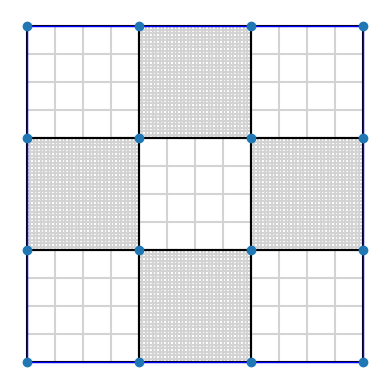

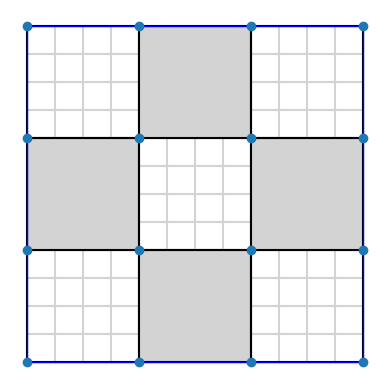

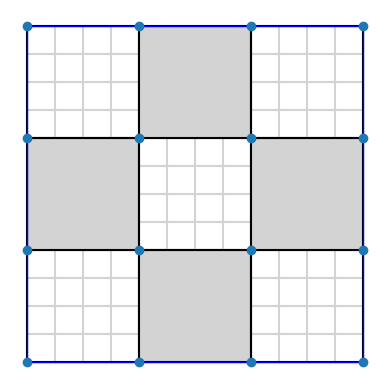

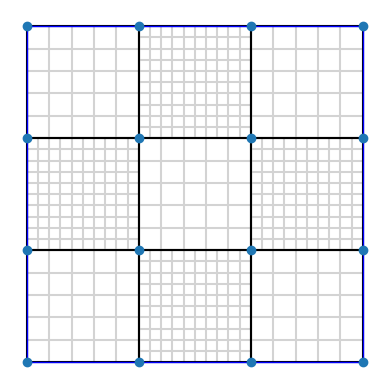

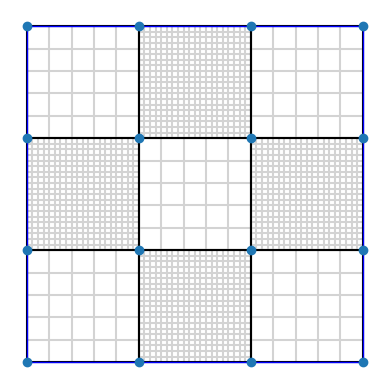

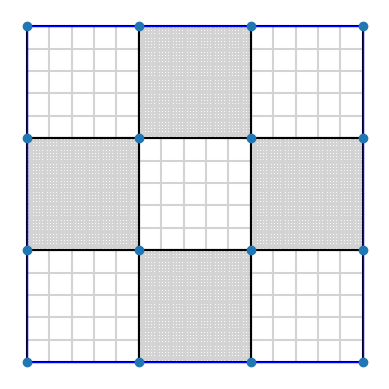

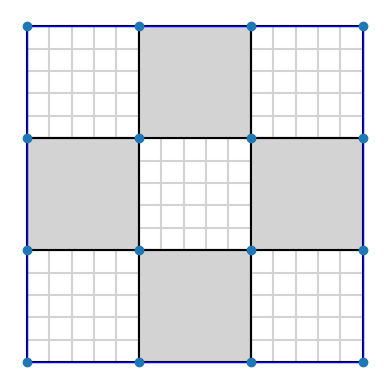

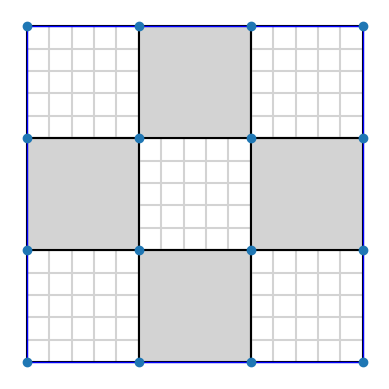

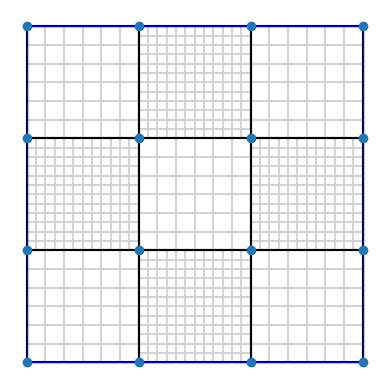

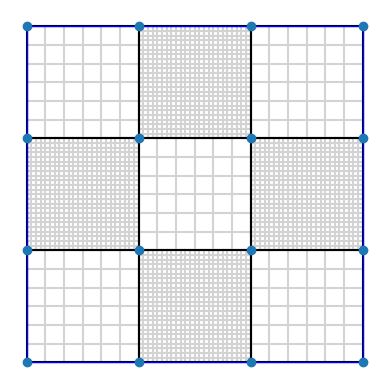

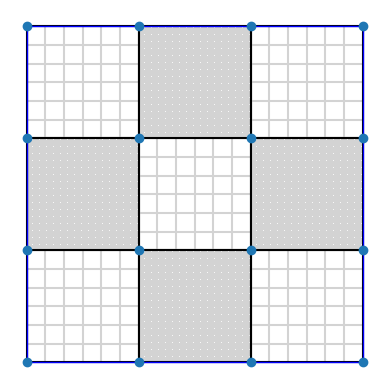

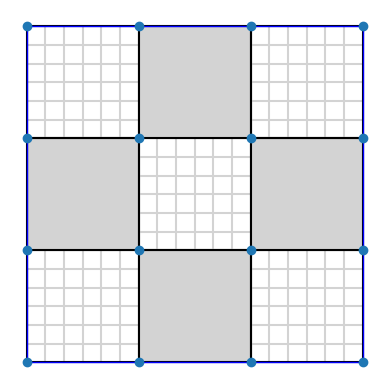

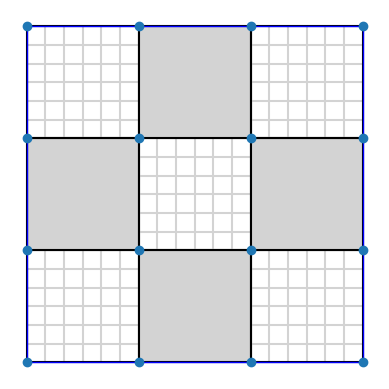

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [ ]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((6,5))
it = np.zeros((6,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(6,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=False)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.08600449562072754 seconds.
Basis setup took 0.014266014099121094 seconds
pcg with preconditioned condition number 1.0972303562262358 stopped after 5 iterations with relres 2.1033830757006824e-11
Refinement took 0.0010564327239990234 seconds for 31 patches.
setting up constraints took 0.07834243774414062 seconds.
Basis setup took 0.013842582702636719 seconds
pcg with preconditioned condition number 1.671463683434546 stopped after 10 iterations with relres 4.9938397508517634e-11
Refinement took 0.0012252330780029297 seconds for 31 patches.
setting up constraints took 0.08354926109313965 seconds.
Basis setup took 0.015346527099609375 seconds
pcg with preconditioned condition number 1.2749844484684212 stopped after 13 iterations with relres 3.0492980297062935e-11
Refinement took 0.00106048583984375 seconds for 31 patches.
setting up constraints took 0.1029202938079834 seconds.
Basis setup took 0.020825624465942383 seconds
